# Exercise 6: Contrast stretching and histogram equalization

https://docs.opencv.org/4.6.0/d5/daf/tutorial_py_histogram_equalization.html

https://docs.opencv.org/4.6.0/d4/d1b/tutorial_histogram_equalization.html

In this exercise you will learn:
- The concepts of contrast stretching and histogram equalization to improve the contrast of an image.

As a first step, let's import the python modules we need.

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

## Contrast stretching

[Contrast Stretching](http://homepages.inf.ed.ac.uk/rbf/HIPR2/stretch.htm) is the same as linear image [Normalization](https://en.wikipedia.org/wiki/Normalization_(image_processing)).

The formula for normalizing a set of values $I$ to the interval $[0,1]$, producing the normalised set $I_{N}$ is:

$$
I_{N}=\frac{I-I_{Min}}{I_{Max}-I_{Min}}
$$

If we want another interval $[newMin, newMax]$ we can just apply a linear transformation to the formula above to get:

$$
I_{N}=\frac{I-I_{Min}}{I_{Max}-I_{Min}} * (newMax - newMin) + newMin
$$

This second formula is also called *Contrast Stretching* when $I$ is an image. In *Contrast Stretching* we want to convert an image $I$ with pixel values in the range $[I_{Min}, I_{Max}]$, to a new image $I_{N}$ with pixel values in the range $[newMin, newMax]$.

Finally, we also want to round the floating-point values to integers again, i.e.:

$$
I_{N}=round\left(\frac{I-I_{Min}}{I_{Max}-I_{Min}} * (newMax - newMin) + newMin\right)
$$

Let's try this on a fake 5x5 grayscale image below.

5x5 grayscale image:

[[138 128 133 131 142]
 [111 128 103 134 114]
 [121 146 142 135 107]
 [120 125 107 146 101]
 [125 120 144 111 124]]

Range: [101, 146]

normalized 5x5 grayscale image:

[[210 153 181 170 232]
 [ 57 153  11 187  74]
 [113 255 232 193  34]
 [108 136  34 255   0]
 [136 108 244  57 130]]

New range: [0, 255]


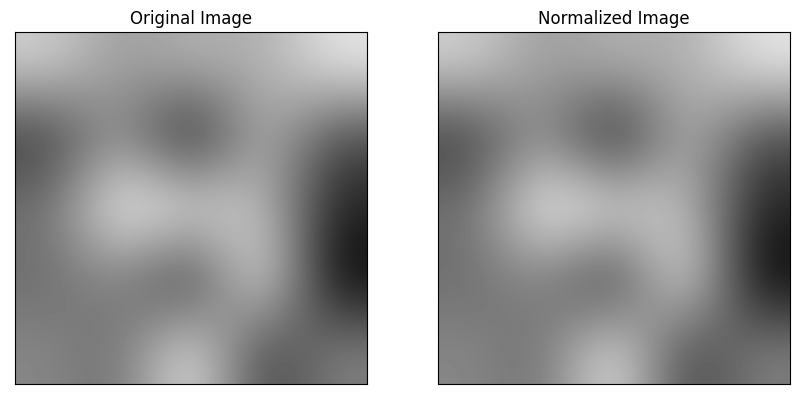

In [2]:
# Create a fake 5x5 grayscale image, with values uniformly drawn from [100,150]
np.random.seed(42)
img = np.random.randint(100, 151, (5,5), dtype=np.uint8)

# Print the image
print(f'5x5 grayscale image:\n\n{img}')

# Print the current range for the pixel values in the image
print(f'\nRange: [{img.min()}, {img.max()}]')

# Let's apply contrast stretching (normalization) to our image
# so that the pixel values are "stretched" to the interval [0,255]
def normalize(img, new_range):
    current_min, current_max = img.min(), img.max()
    (new_min, new_max) = new_range
    img_norm = (img - current_min) / (current_max - current_min)
    img_norm = img_norm * new_max + new_min
    img_norm = np.around(img_norm)
    return img_norm.astype(np.uint8)
img_norm = normalize(img, [0,255])

# Print the normalised image
print(f'\nnormalized 5x5 grayscale image:\n\n{img_norm}')

# Print the new range for the pixel values in the normalized image
print(f'\nNew range: [{img_norm.min()}, {img_norm.max()}]')

# Let's plot the two images and compare them with each other
plt.figure(figsize=(10,5))
plt.subplot(1,2,1), plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.imshow(img, cmap="gray", interpolation="bicubic")
plt.subplot(1,2,2), plt.title('Normalized Image'), plt.xticks([]), plt.yticks([])
plt.imshow(img_norm, cmap="gray", interpolation="bicubic");

## Contrast stretching with OpenCV

We don't have to write our own normalization function, since OpenCV provides the `cv.normalize()` function.

`dst = cv.normalize(src, dst, alpha, beta, norm_type)`
- `src`: the source image to normalize.
- `dst`: the destination image (we can pass `None` here to obtain the destination image as the function's return value).
- `alpha`: the desired (new) minimum value.
- `beta`: the desired (new) maximum value.
- `norm_type`: the type of normalization desired (the value `cv.NORM_MINMAX` will give us normal contrast stretching).

In [3]:
# Apply contrast stretching (normalization) to the image,
# using OpenCV's function, to obtain the new range [0, 255].
img_norm2 = cv.normalize(img, None, 0, 255, cv.NORM_MINMAX)

# Let's make sure our own function 'normalize(img, new_range)'
# gives the same result as OpenCV's 'cv.normalize()' function.
print(f'Both functions produce the same results: {np.all(img_norm == img_norm2)}')

Both functions produce the same results: True


## Histogram equalization

[Histogram equalization](https://en.wikipedia.org/wiki/Histogram_equalization) is a non-linear transformation (normalization) of an image's pixel values.

<p>
<img width="200" height="100" src="../notebook_images/histogram_equalization.png" style="padding: 10px; float: right;">

Consider an image whose pixel values are confined to some specific range of values. For example, a brighter image will have all pixels confined to high values. An image with good contrast will have pixel values across the entire available range (\[0,255\] for an 8-bit color channel or grayscale image). Therefore we can stretch a histogram so that it has values across the entire range of available values. This is what *Histogram Equalization* does, but in a non-linear way, compared to normal *Contrast Stretching*. This normally improves the contrast of an image, and usually gives a better result than normal contrast stretching.
</p>

Histogram equalization consists of the following steps:

1. Calculate the image's Histogram $\mathcal{H} (i) = n_{i}$.
2. Calculate the Cumulative Histogram (let's call this CDF) $\mathcal{H}'(j)=\sum_{0 \leq i<j} \mathcal{H} (i)$.
3. Normalize the Cumulative Histogram (CDF) to the interval $[newMin, newMax]$ ($[0,255]$ for an 8-bit color/grayscale channel) for all values > 0, giving us the normalized cumulative histogram (CDF) $\mathcal{H}'_{N}$.
4. Use the normalized Cumulative Histogram (CDF) to map the original pixel values to the equalized values: $equalized\_value = \mathcal{H}'_{N}(original\_value)$

## Example

<p>

<img width="200" height="200" src="../notebook_images/equalization_sample_1.png" style="padding: 10px; float: right;">

Assume we have the 8-bit grayscale image with the values shown to the right.

1. The histogram for this image is shown in the table below (pixel values with zero count excluded).

|Value|Count|Value|Count|Value|Count|Value|Count|Value|Count|
|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|
|52|1|64|2|72|1|85|2|113|1|
|55|3|65|3|73|2|87|1|122|1|
|58|2|66|2|75|1|88|1|126|1|
|59|3|67|1|76|1|90|1|144|1|
|60|1|68|5|77|1|94|1|154|1|
|61|4|69|3|78|1|104|2|	
|62|1|70|4|79|2|106|1|
|63|2|71|2|83|1|109|1|

2. The cululative histogram (CDF) is shown in the table below (non-contributing pixel values excluded).

|Value|Count|Value|Count|Value|Count|Value|Count|Value|Count|
|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|
|52| 1|64|19|72|40|85|51|113|60|
|55| 4|65|22|73|42|87|52|122|61|
|58| 6|66|24|75|43|88|53|126|62|
|59| 9|67|25|76|44|90|54|144|63|
|60|10|68|30|77|45|94|55|154|64|
|61|14|69|33|78|46|104|57|	
|62|15|70|37|79|48|106|58|
|63|17|71|39|83|49|109|59|

3. Just as we normalized the pixel values for an image $I$ between a certain range $[newMin,newMax]$ in contrast stretching, we do the same normalization for the Cumuluative Histogram (CDF) in Histogram Equalization. In other words, we want to normalize the CDF to a certain range $[newMin,newMax]$ (not the image). The only exception is that we want to use the smallest non-zero CDF value instead of the minimum CDF value (in case this is zero) in the formula below, and we also want to round the final floating-point values to integers:

$$
CDF_{N}=round\left(\frac{CDF-CDF_{nonZeroMin}}{CDF_{Max}-CDF_{nonZeroMin}} * (newMax - newMin) + newMin\right)
$$

For an 8-bit color/grayscale channel we want to normalize the CDF to the interval $[newMin, newMax] = [0, 255]$. And in our example the smallest non-zero CDF value is $nonZeroMin = 1$ and the biggest value is $Max = 64$. Therefore, the formula becomes as below for our example:

$$
CDF_{N} = round\left( \frac{CDF-1}{64-1} * (255 - 0) + 0 \right) = round\left( \frac{CDF-1}{64-1} * 255 \right)
$$

If we apply this to the smallest non-zero CDF value (1) we get:

$$
CDF_{N} = round\left( \frac{1-1}{64-1} * 255 \right) = round(0) = 0
$$

If we apply this to the biggest CDF value (64) we get:

$$
CDF_{N} = round\left( \frac{64-1}{64-1} * 255 \right) = round(255) = 255
$$

**Note**: all zero (0) CDF values keep their zero values and should not be normalized by the formula. If we want to calculate the equalized histogram ourselves, we can use the two numpy functions
[np.ma.masked_equal()](https://numpy.org/doc/stable/reference/generated/numpy.ma.masked_equal.html) and [np.ma.filled()](https://numpy.org/doc/stable/reference/generated/numpy.ma.filled.html) to mask out zero (0) CDF values before the formula is applied, and respectively, to mask in the zero (0) values again after the formula has been applied.

The normalized cululative histogram (CDF) is shown in the table below (same previous values excluded).

|Value|Count|Value|Count|Value|Count|Value|Count|Value|Count|
|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|
|52| 0|64|73|72|158|85|202|113|239|
|55|12|65|85|73|166|87|206|122|243|
|58|20|66|93|75|170|88|210|126|247|
|59|32|67|97|76|174|90|215|144|251|
|60|36|68|117|77|178|94|219|154|255|
|61|53|69|130|78|182|104|227|	
|62|57|70|146|79|190|106|231|
|63|65|71|154|83|194|109|235|

<img width="200" height="200" src="../notebook_images/equalization_sample_2.png" style="padding: 10px; float: right;">

4. Finally, we can use the normalized cumulative histogram (CDF) to map the original pixel values to equalized values:

$$
equalized\_pixel\_value = CDF_{N}(original\_pixel\_value)
$$

</p>

<img width="400" height="400" src="../notebook_images/histogram_mapping.png" style="padding: 10px">

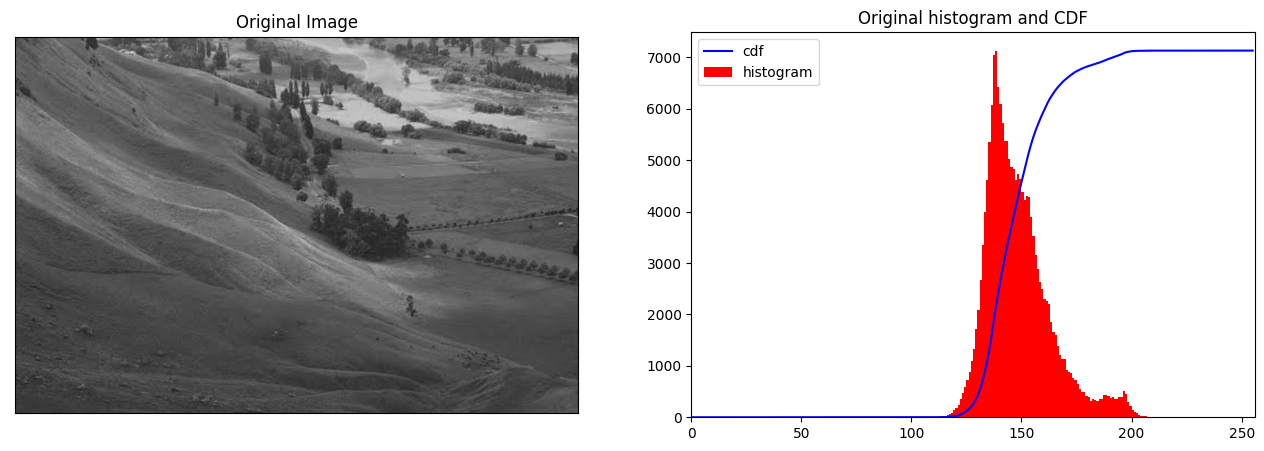

In [4]:
# Read image as grayscale
img = cv.imread('../data/wiki.jpg', 0)

# Step 1. Calculate the image's histogram
hist, bins = np.histogram(img.flatten(), 256, [0,256])

# Step 2. Calculate the Cummulative Distribution Function (CDF),
# i.e. just compute a running sum of the histogram's bins.
cdf = hist.cumsum() # or cdf = np.cumsum(hist)

# Scale the CDF so that it has the same max value as 'hist' (only needed for plotting)
cdf_scaled = cdf * float(hist.max()) / cdf.max()

# Plot image
plt.figure(figsize=(16,5))
plt.subplot(121), plt.imshow(img, cmap="gray", interpolation="bicubic")
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

# Plot histogram and scaled CDF
plt.subplot(122)
plt.plot(cdf_scaled, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.title('Original histogram and CDF'),
plt.legend(('cdf','histogram'), loc = 'upper left')

plt.show()

In the plot above, you can see that the histogram lies in the brighter region. We want to equalize the histogram so we use the full spectrum. For that, we need a transformation function that maps the input pixels in the brighter region to output pixels in the full region. That's what histogram equalization does for us.

We will mask out zero values from the original CDF using the numpy function:

`cdf_masked = np.ma.masked_equal(cdf, 0)`

Then we will normalize the masked CDF to the interval $[0, 255]$:

`cdf_masked_normalized = ( (cdf_masked - cdf_masked.min()) / (cdf_masked.max() - cdf_masked.min()) ) * 255`

Lastly, we will mask in the zero values again using the numpy function:

`cdf_normalized = np.ma.filled(cdf_masked_normalized, 0).astype('uint8')`

When we have the normalized CDF, we can transform the original pixel values to equalized pixel values:

`img_equalized = cdf_normalized[img]`

In [5]:
# Step 3. Normalize the CDF

# First, mask out all zero values in the CDF
cdf_masked = np.ma.masked_equal(cdf, 0)

# Normalize the masked CDF
cdf_masked_normalized = ((cdf_masked - cdf_masked.min()) / (cdf_masked.max() - cdf_masked.min())) * 255

# Mask in the zero values again to obtain the final normalized CDF
cdf_normalized = np.ma.filled(cdf_masked_normalized, 0).astype('uint8')

# Step 4. Convert the original pixel values to equalized pixel values
img_equalized = cdf_normalized[img]

Let's re-calculate and plot the histogram and CDF from the equalized values.

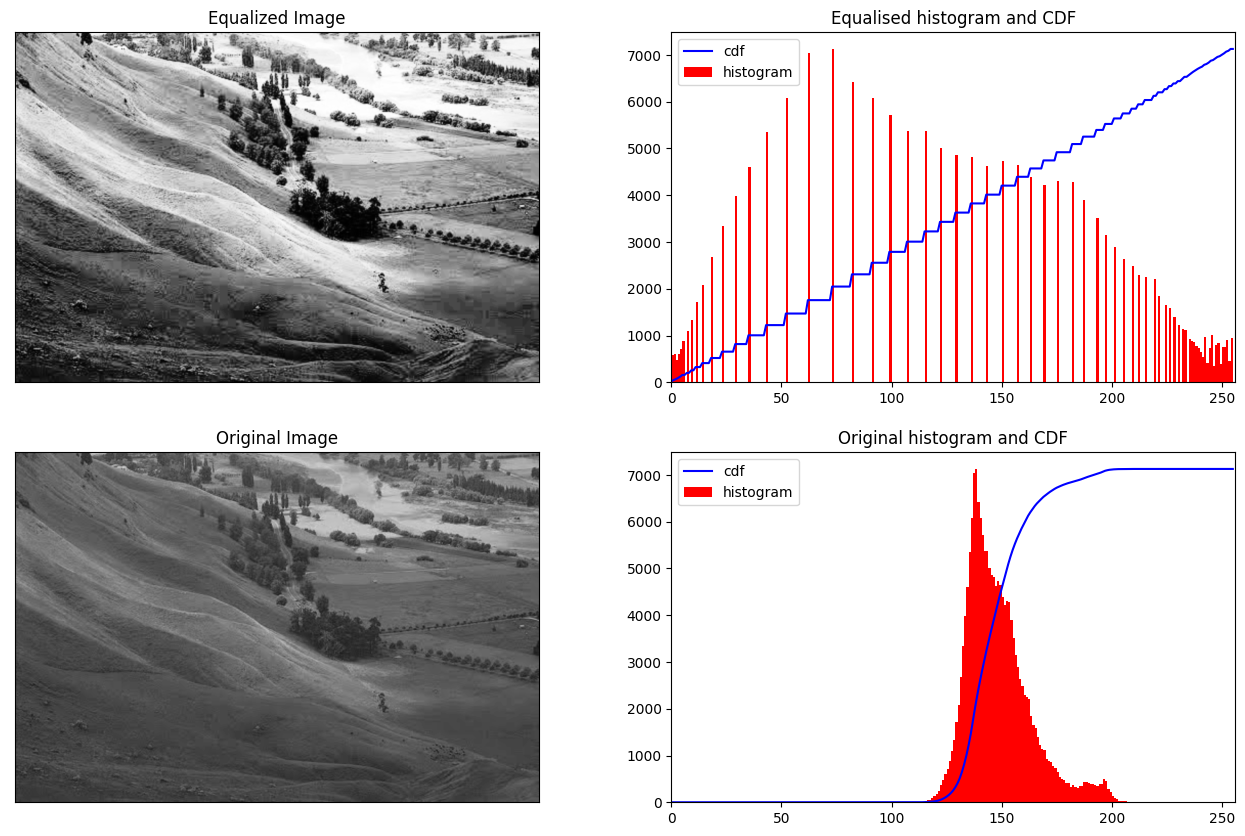

In [6]:
# Calculate the image's equalized histogram
hist_equalized, bins = np.histogram(img_equalized.flatten(), 256, [0,256])

# Calculate the equalized Cumulative Distribution Function (CDF),
# i.e. just compute a running sum of the histogram's bins.
cdf_equalized = hist_equalized.cumsum() # or cdf = np.cumsum(hist_equalized)

# Scale the CDF so that it has the same range (max value) as 'hist_equalized'
cdf_equalized_scaled = cdf_equalized * float(hist_equalized.max()) / cdf_equalized.max()

# Plot image
plt.figure(figsize=(16,10))
plt.subplot(221), plt.imshow(img_equalized, cmap="gray", interpolation="bicubic")
plt.title('Equalized Image'), plt.xticks([]), plt.yticks([])

# Plot histogram and scaled CDF curve
plt.subplot(222)
plt.plot(cdf_equalized_scaled, color = 'b')
plt.hist(img_equalized.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.title('Equalised histogram and CDF'),
plt.legend(('cdf','histogram'), loc = 'upper left')

# Let's plot the original image again so we can compare it to the equalized image
plt.subplot(223), plt.imshow(img, cmap="gray", interpolation="bicubic")
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

# Let's plot the original histogram and scaled CDF again
# so we can compare it to equalized histogram and scaled CDF
plt.subplot(224)
plt.plot(cdf_scaled, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.title('Original histogram and CDF'),
plt.legend(('cdf','histogram'), loc = 'upper left')

plt.show()

## Histogram equalization in OpenCV

Luckily, OpenCV has a built-in function `cv.equalizeHist()` to do histogram equalization for us. Its input is a grayscale image and its output is the histogram equalized image.

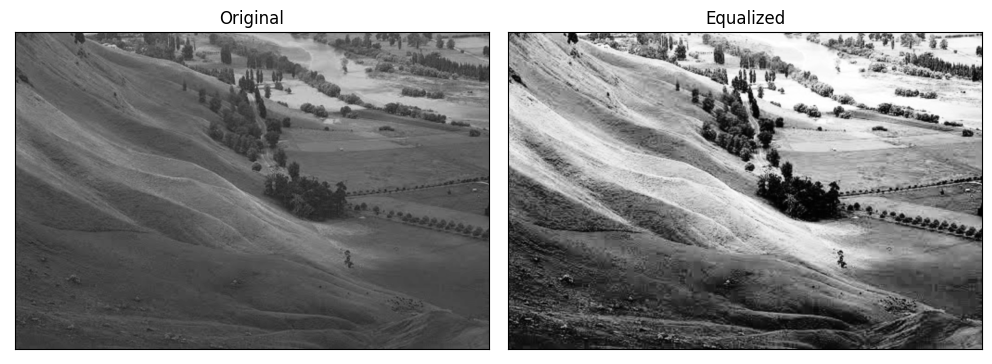

In [7]:
# Read in an image as grayscale
img = cv.imread('../data/wiki.jpg', 0)

# Equalise the image
img_equalized = cv.equalizeHist(img)

# Plot the original image
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(img, cmap="gray", interpolation="bicubic")
plt.title('Original'), plt.xticks([]), plt.yticks([])

# Plot the equalized image
plt.subplot(222), plt.imshow(img_equalized, cmap="gray", interpolation="bicubic")
plt.title('Equalized'), plt.xticks([]), plt.yticks([])

plt.tight_layout(pad=1.0)
plt.show()